## Load libraries

In [7]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load a model

In [2]:
vae = VAEUtils(directory='../models/zinc_properties')

/home/beangoben/miniconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [3]:
smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : ClCC(=O)N)C(=O)c1c(C)oc(C)c1C
Z representation     : (1, 196) with norm 10.686


## property preditor

In [4]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[ 0.77286768  2.43317604  0.95585614]


## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 9 unique mols, out of 76
SMILES
 0    CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
1    COCC(=O)NNC(=O)c1c(C)oc(C)c1C
2    CSC(C=O)NNC(=O)c1c(C)oc(C)c1C
3    CSCC(=O)NCC(=O)c1c(C)oc(C)c1C
4    COCC(=O)NCC(=O)c1c(C)oc(C)c1C
5    CSC(C=O)NCC(=O)c1c(C)oc(C)c1C
6    COC(C=O)NCC(=O)c1c(C)oc(C)c1C
7    ClCC(=O)NCC(=O)c1c(C)oc(C)c1C
8    ClC(C=O)NNC(=O)c1c(C)oc(C)c1C
Name: smiles, dtype: object


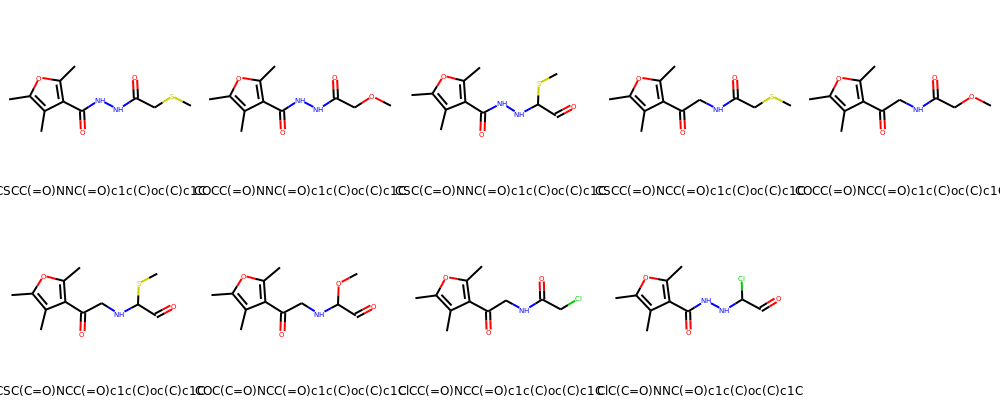

,smiles,distance,count,frequency,mol
0,CSCC(=O)NNC(=O)c1c(C)oc(C)c1C,0.000005,8,0.105263,"<img src="""" alt=""Mol""/>"
1,COCC(=O)NNC(=O)c1c(C)oc(C)c1C,2.962132,1,0.013158,"<img src="""" alt=""Mol""/>"
2,CSC(C=O)NNC(=O)c1c(C)oc(C)c1C,3.176160,7,0.092105,"<img src="""" alt=""Mol""/>"
3,CSCC(=O)NCC(=O)c1c(C)oc(C)c1C,4.748783,30,0.394737,"<img src="""" alt=""Mol""/>"
4,COCC(=O)NCC(=O)c1c(C)oc(C)c1C,5.269174,7,0.092105,"<img src="""" alt=""Mol""/>"

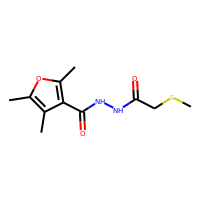
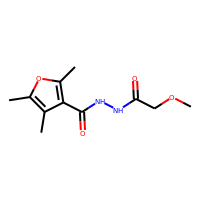
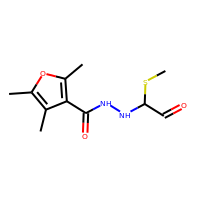
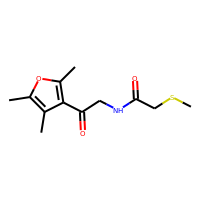
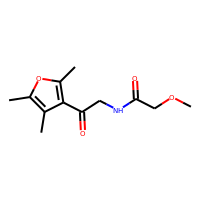

In [5]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## PCA of latent space

Sample random points from the training set along with properties

In [10]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,195595,2.00802,0.758808,2.894624,COc1ncc(-c2cc(-c3c(C)n[nH]c3C)nc(N)c2C#N)cn1
1,51196,3.38800,0.829912,2.764101,C[C@@H]1CCC[C@H](NC(=O)Nc2cccc(OCC(=O)N3CCCC3)c2)C1
2,75832,2.11620,0.847740,2.947644,CC[C@H]1CN(CCN2CCOC2=O)c2ccccc2O1
3,12236,3.20600,0.681065,3.019252,O=C(Nc1ccc(Br)c2ccccc12)[C@@H]1C[C@H]1[N+](=O)[O-]
4,37851,1.84862,0.877055,4.509973,Cc1ccsc1CN1C[C@H](C(C)C)[NH2+]C[C@@H]1C


Perform a PCA projection and color the points based on a property

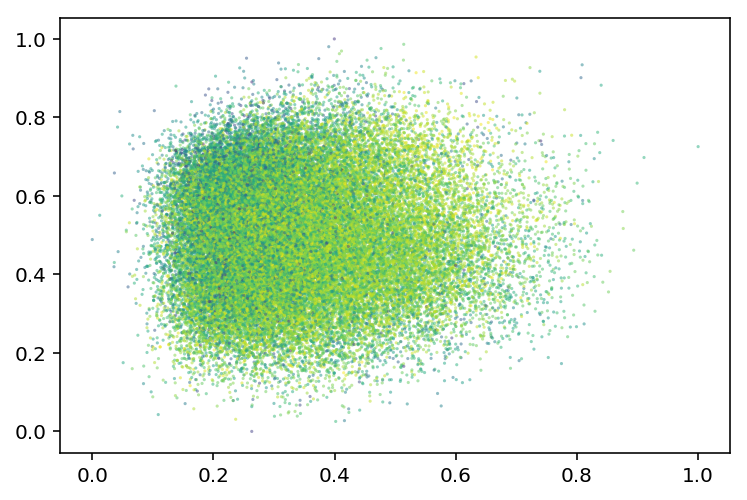

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [ ]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()